# 🍕 Introduction to Slice Discovery with `domino`

This notebook introduces Domino, a method for identifying slices of data on which a machine learning model underperforms. 


**Useful links:**
- 📄 [ICLR 2022 Paper](https://arxiv.org/abs/2203.14960)
- 💻 [GitHub](https://github.com/HazyResearch/domino)
- 📘 [Docs](https://domino-slice.readthedocs.io/en/latest/)
- 🌍 [BlogPost]()

In [ ]:
!pip install "domino[clip] @ git+https://github.com/HazyResearch/domino@main"
!pip install git+https://github.com/openai/CLIP.git

In [3]:
from domino import explore, DominoSlicer
import meerkat as mk

In [ ]:
# if you don't have access to a GPU, set this to `DEVICE="cpu"`
# if you are running this notebook on Google colab, you can use a GPU by going to 
# "Runtime" -> "Change runtime type" and selecting "GPU" under Hardware accelerator
DEVICE = 0

## 💾 Downloading the data
First, we'll download some data to explore. We're going to use the [Imagenette dataset](https://github.com/fastai/imagenette#image%E7%BD%91), a small subset of the original [ImageNet](https://www.image-net.org/update-mar-11-2021.php).  This dataset is made up of 10 classes (e.g. "garbage truck", "gas pump", "golf ball").
- Download time: <1 minute
- Download size: 130M

In [16]:
import os

dp = mk.datasets.get("imagenette")

# we'll only be using the validation data
dp = dp.lz[dp["split"] == "valid"]

## 🤖 Loading a model and computing predictions
Next, we'll load in the model we are going to audit: a ResNet18 pretrained on the full ImageNet (courtesy of [TorchVision](https://pytorch.org/vision/stable/models.html)). We'll compute the model's prediction for each example in the Imagenette validation dataset we loaded above. 

In [17]:
import torch
from torchvision.models import resnet18
import torchvision.transforms as transforms
model = resnet18(pretrained=True)

In [18]:
# 1. Define transform
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
])

# 2. Create new column with transform 
dp["input"] = dp["img"].to_lambda(transform)

In [19]:
# 1. Move the model to device
model.to(DEVICE).eval()

# 2. Define a function that runs a forward pass over a batch 
@torch.no_grad()
def predict(batch: mk.DataPanel):
    input_col: mk.TensorColumn = batch["input"] 
    x: torch.Tensor = input_col.data.to(DEVICE)  # We get the underlying torch tensor with `data` and move to GPU 
    out: torch.Tensor = model(x)  # Run forward pass

    # Return a dictionary with one key for each of the new columns. Each value in the
    # dictionary should have the same length as the batch. 
    return {
        "pred": out.cpu().numpy().argmax(axis=-1),
        "probs": torch.softmax(out, axis=-1).cpu().numpy(),
    }

# 3. Apply the update. Note that the `predict` function operates on batches, so we set 
# `is_batched_fn=True`. Also, the `predict` function only accesses the "input" column, by 
# specifying that here we instruct update to only load that one column and skip others 
dp = dp.update(
    function=predict,
    is_batched_fn=True,
    batch_size=32,
    input_columns=["input"], 
    pbar=True
)

  0%|          | 0/123 [00:00<?, ?it/s]

In [4]:
import hashlib

import hashlib
x = "helo"
int.from_bytes(hashlib.sha256(x.encode('utf-8')).digest(), 'big') % 100


34

## 🎯 Computing average metrics

Next we'll compute metrics for one of the classes: "gas pump". 

In [43]:
dp["correct"] = dp["pred"] == mk.NumpyArrayColumn(dp["label_idx"])
accuracy = dp["correct"].mean()
print(f"Micro accuracy across the ten Imagenette classes: {accuracy:0.3}")

Micro accuracy across the ten Imagenette classes: 0.672


## 🔎 Discovering underperforming slices

Although the model performs quite well on average, it may still underperform on interesting slices of data. Slice Discovery Methods (SDM) are automated algorithms that aim to identify these slices.  Most SDMs adhere to a three-step procedure highlighted in the figure below: (1) embed, (2) slice, and (3) describe.  For each of these steps, the `domino` package provides implementations of various algorithms under a common API. This makes it easy to compose a custom slice discovery method from different choices for each step.

<div>
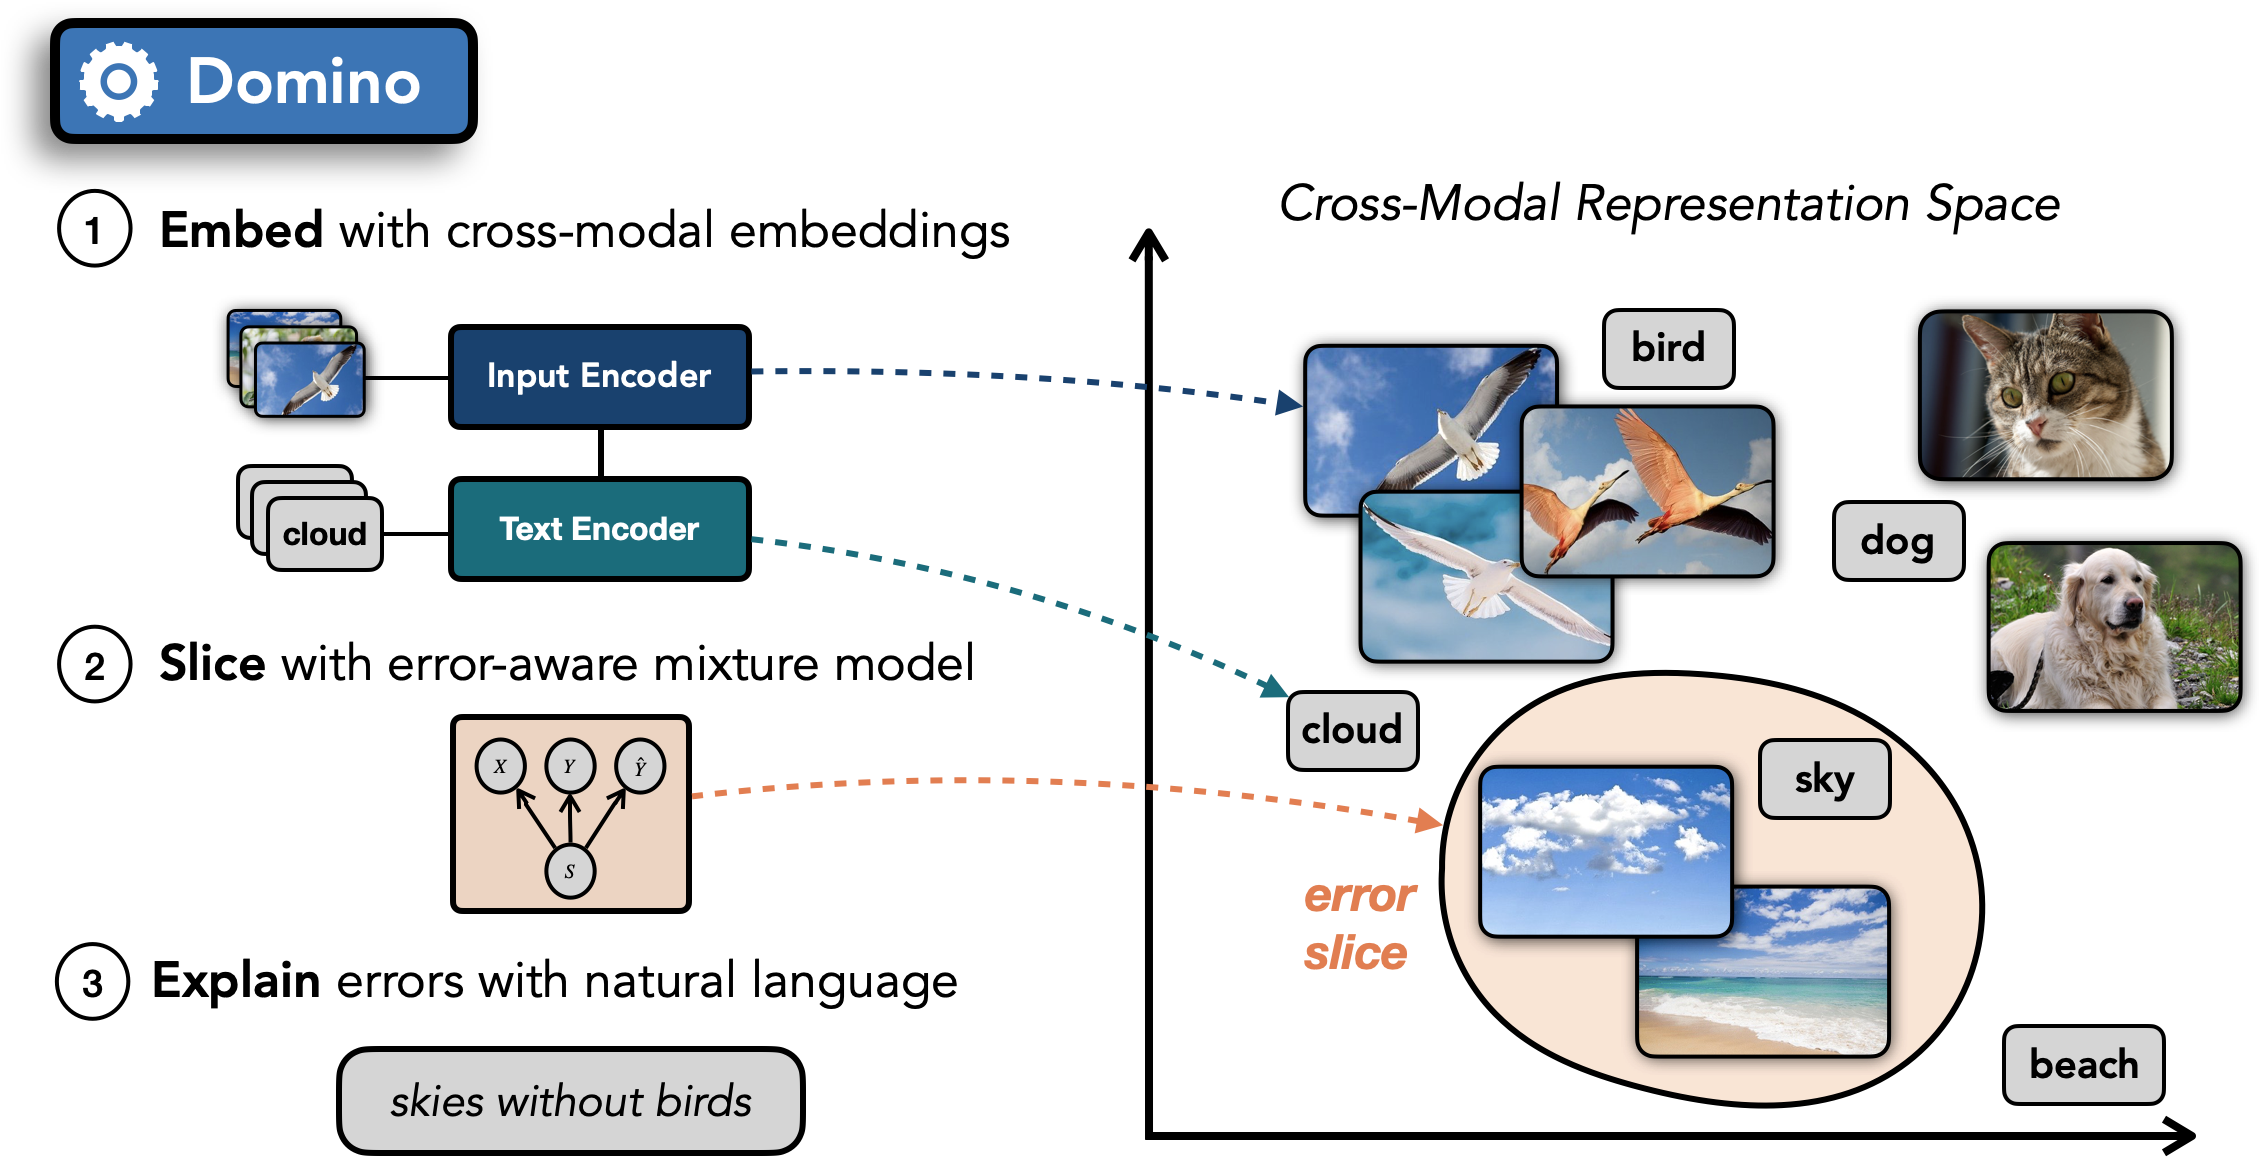
</div>


Below, we use `domino` to discover slices of the Imagenette data on which the model underperforms.
We'll focus on one class at a time when discovering slices in this tutorial. Below, we start with the class "gas pump", but feel free to try a different class by changing the `LABEL_IDX` constant. 

```
{'cassette player': 482,
 'garbage truck': 569,
 'tench': 0,
 'english springer spaniel': 217,
 'church': 497,
 'parachute': 701,
 'french horn': 566,
 'chainsaw': 491,
 'golf ball': 574,
 'gas pump': 571}
```

In [44]:
LABEL_IDX = 571

# convert to a binary task 
dp["prob"] = dp["probs"][:, LABEL_IDX]
dp["target"] = (dp["label_idx"] == LABEL_IDX)


### 📊 1. Embed

Domino encodes the validation images alongside text in a cross-modal embedding space using a model like CLIP.

In [21]:
from domino import embed
dp = embed(
    dp, 
    input_col="img",
    encoder="clip", 
    device=DEVICE
)

  0%|          | 0/31 [00:00<?, ?it/s]

### 🍕 2. Slice

Using an error-aware mixture model, Domino identifies regions in the embedding space with a high concentration of errors.

In [34]:
domino = DominoSlicer(
    y_log_likelihood_weight=40,
    y_hat_log_likelihood_weight=40,
    n_mixture_components=25,
    n_slices=5
)

domino.fit(data=dp, embeddings="clip(img)", targets="target", pred_probs="prob")

dp["domino_slices"] = domino.predict_proba(
    data=dp, embeddings="clip(img)", targets="target", pred_probs="prob"
)

  0%|          | 0/100 [00:00<?, ?it/s]

### ✏️ 3. Describe

Finally, to help practitioners understand the commonalities among the examples in each slice, Domino generates natural language descriptions of the slices. To do so, it leverages the cross-modal embeddings computed in Step 1, surfacing the text nearest to the slice in embedding space.

In [22]:
from domino import generate_candidate_descriptions
phrase_templates = [
    "a photo of [MASK].",
    "a photo of {} [MASK].",
    "a photo of [MASK] {}.",
    "a photo of [MASK] {} [MASK].",
]

text_dp = generate_candidate_descriptions(
    templates=phrase_templates,
    num_candidates=10_000
)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/625 [00:00<?, ?it/s]

In [23]:
text_dp = embed(
    text_dp, 
    input_col="output_phrase", 
    encoder="clip",
    device=DEVICE
)

  0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
from domino import describe

dp["target"] = dp["target"].astype(int)

descriptions = describe(
    data=dp,
    embeddings="clip(img)",
    targets="target",
    slices="domino_slices",
    text=text_dp,
    text_embeddings="clip(output_phrase)",
    slice_idx=0
)
descriptions.lz[(-descriptions["score"]).argsort()][:10]

## 🧗🏾 Exploring discovered slices 

In [41]:
explore(
    data=dp["img_path", "img", "label", "prob", "target", "clip(img)", "domino_slices"],
    embeddings="clip(img)",
    pred_probs="prob",
    targets="target",
    slices="domino_slices",
    text=text_dp,
    text_embeddings="clip(output_phrase)",
) 

FloatSlider(value=0.5, continuous_update=False, description='Slice Inclusion Threshold', max=1.0, readout_form…

Output()